In [1]:
import sys
sys.path.append('../')
from src.CGD import AA_model, AA_trainer
from scipy.spatial import ConvexHull
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from src.utils.AA_visualize import plot_AA, plot_AA_simple, plot_AA_reconstructed, plot_AA_reconstructed_angle, plot_AA_reconstructed_angles_multiple, plot_AA_reconstructed_angles_multiple_sep

# Toy data

In [3]:
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = 20

var = 0.2
rad = (np.cos(30/(180/np.pi))*3)
X1 = np.random.multivariate_normal([0,0],[[var,0],[0,var]],n).T
X2 = np.random.multivariate_normal([1.5,rad],[[var,0],[0,var]],n).T
X3 = np.random.multivariate_normal([-1.5,rad],[[var,0],[0,var]],n).T

X = np.concatenate((X1,X2,X3),axis=1)

data = torch.tensor(X).to(device)

labels = np.concatenate((np.zeros(n),np.ones(n),2*np.ones(n))).astype(int)

K = 3
model = AA_model.AA(X=data,num_comp=K,class_weigts=torch.tensor([1/3,1/3,1/3]).to(device), model='AA')
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6)

C, S = model.get_model_params(get_numpy=True)  # C, S is numpy array

Device:  cuda


 25%|██▍       | 2453/10000 [00:09<00:28, 266.45it/s]

Tolerance reached at 2454 number of iterations


# Plots

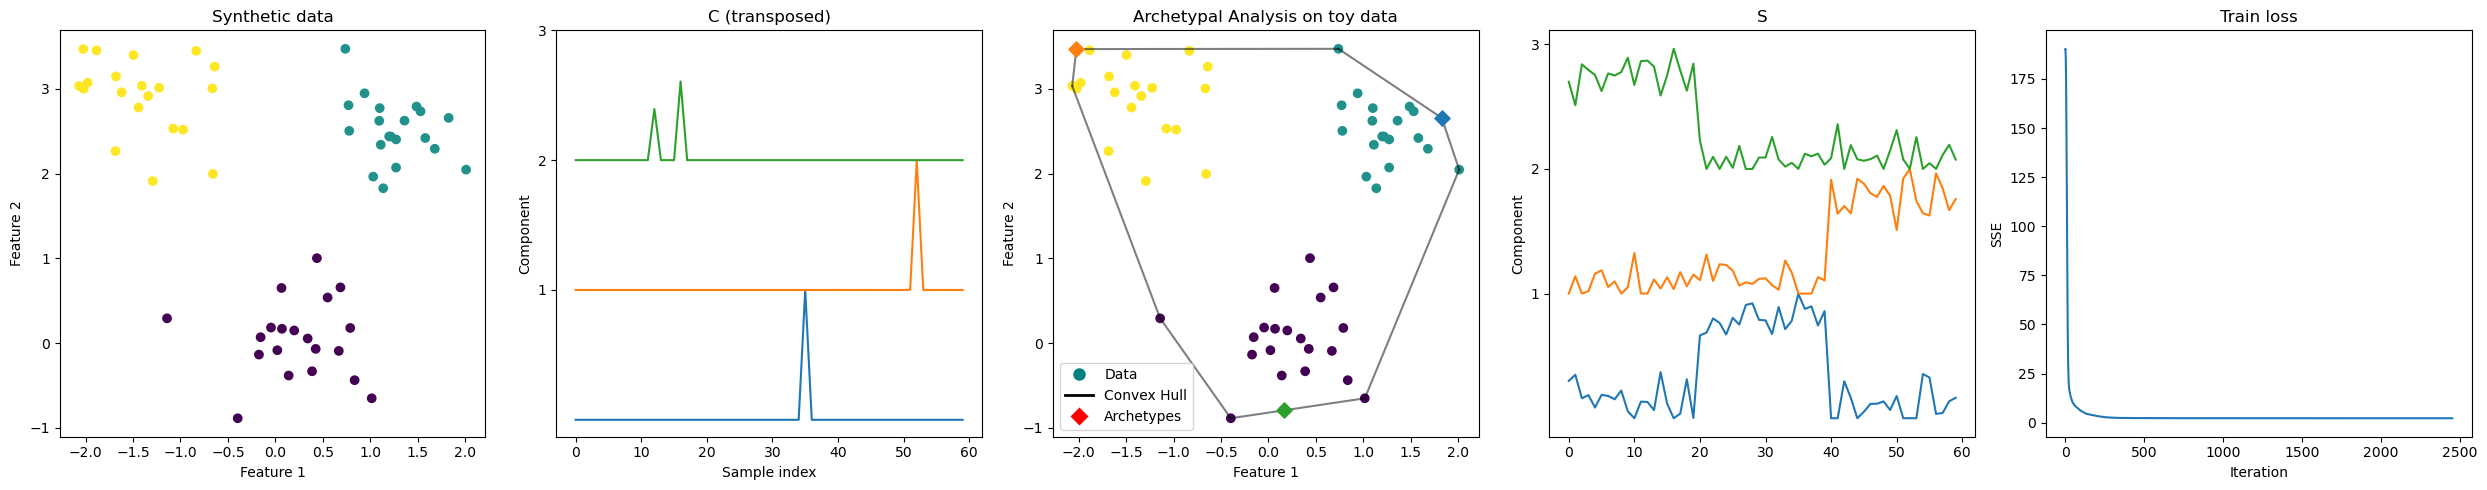

In [4]:
plot_AA(X, C, S, K, loss, labels)

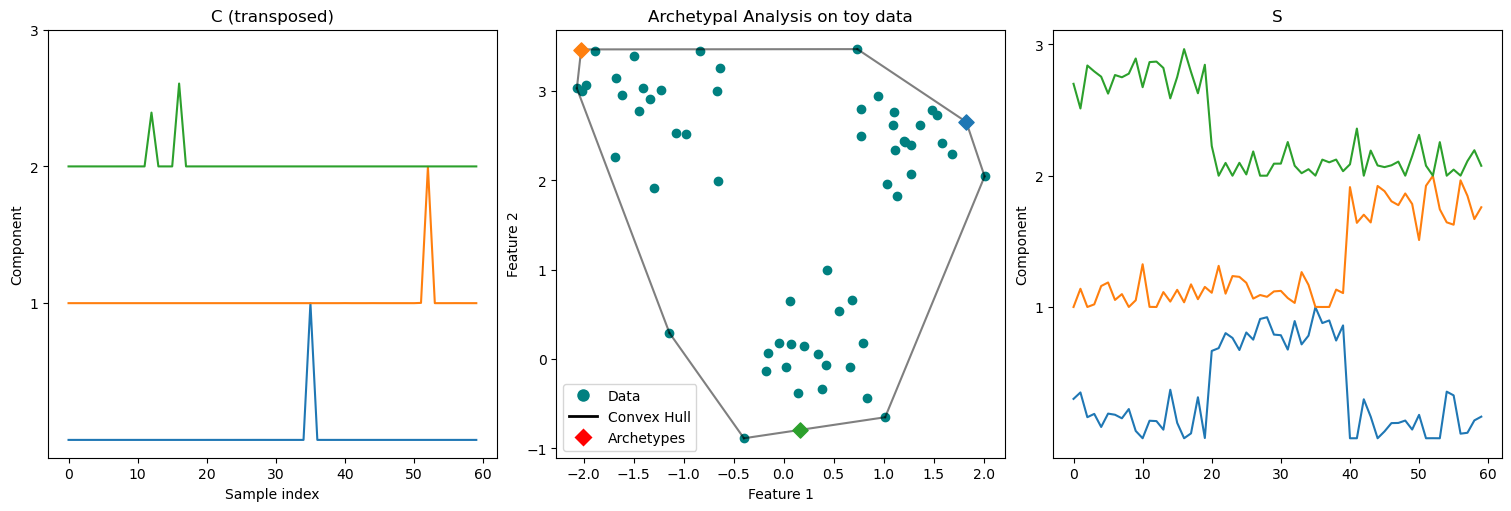

In [5]:
plot_AA_simple(X, C, S, K)

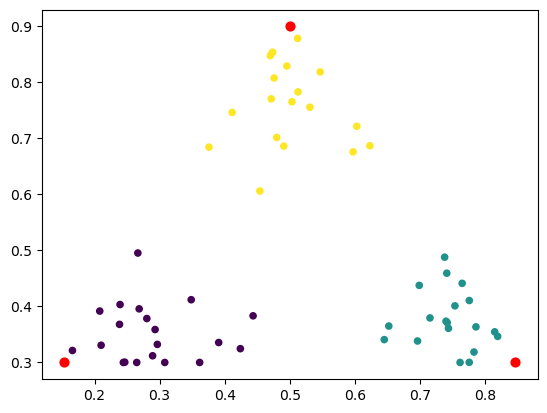

In [6]:
plot_AA_reconstructed(X, C, S, K, y=labels, recon_order_points=10, point_size=20)

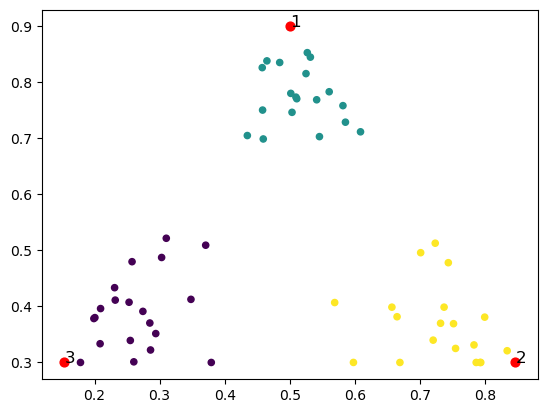

In [7]:
plot_AA_reconstructed_angle(X, C, S, K, y=labels, point_size=20)

# Real Data

In [30]:
import torch
import numpy as np
import pandas as pd
import numpy as np
import pickle
import os

load = np.load('../src/data/lab1.npy')
df = pd.DataFrame(load, columns=['slowdelta', 'fastdelta', 'slowtheta', 'fasttheta', 'alpha', 'beta', 'rms', 'sleepstage'])

X = df.drop(columns=['sleepstage'])
#X = (X - X.mean()) / X.std()
print(X.describe().round(2))
y = df['sleepstage']
X = X.to_numpy()
y = y.to_numpy()
X = X.T
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

idx = []
for i in range(1, 4):
    idx.extend(np.random.choice(np.where(y == i)[0], 30000))

sorted_idx = np.sort(idx)
X = X[:, sorted_idx]
data = torch.tensor(X).to(device)
y = (y[sorted_idx]).astype(int)

       slowdelta  fastdelta  slowtheta  fasttheta      alpha       beta  \
count  619534.00  619534.00  619534.00  619534.00  619534.00  619534.00   
mean        0.23       0.20       0.25       0.10       0.11       0.08   
std         0.14       0.11       0.11       0.07       0.06       0.04   
min         0.00       0.00       0.00       0.00       0.00       0.00   
25%         0.13       0.12       0.17       0.05       0.07       0.05   
50%         0.20       0.18       0.23       0.08       0.10       0.07   
75%         0.30       0.26       0.31       0.13       0.14       0.09   
max         0.93       0.97       0.88       0.78       0.86       0.93   

             rms  
count  619534.00  
mean        0.85  
std         0.48  
min         0.06  
25%         0.36  
50%         0.93  
75%         1.31  
max         1.93  


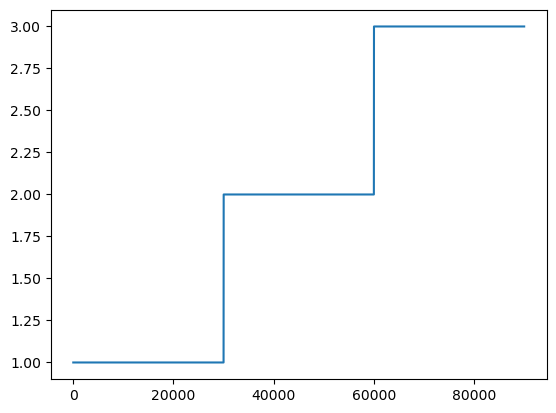

In [38]:
plt.plot(y)

In [32]:
from tqdm import tqdm
K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

C_list = []
S_list = []

for K in tqdm(K_list):
    model = AA_model.AA(X=data,num_comp=K,class_weigts=torch.tensor([1, 1, 1]).to(device),model='AA', verbose=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6, disable_output=True)
    C, S = model.get_model_params()
    C_list.append(C)
    S_list.append(S)
    
# save the two list, they contain the C and S matrices for each K, but they have different shapes, so np.save does not work
import pickle
with open('../src/data/C_list_RMS.pkl', 'wb') as f:
    pickle.dump(C_list, f)
with open('../src/data/S_list_RMS.pkl', 'wb') as f:
    pickle.dump(S_list, f)

100%|██████████| 9/9 [02:40<00:00, 17.84s/it]


In [33]:
# import files again
import pickle
with open('../src/data/C_list_RMS.pkl', 'rb') as f:
    C_list = pickle.load(f)

with open('../src/data/S_list_RMS.pkl', 'rb') as f:
    S_list = pickle.load(f)

K_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

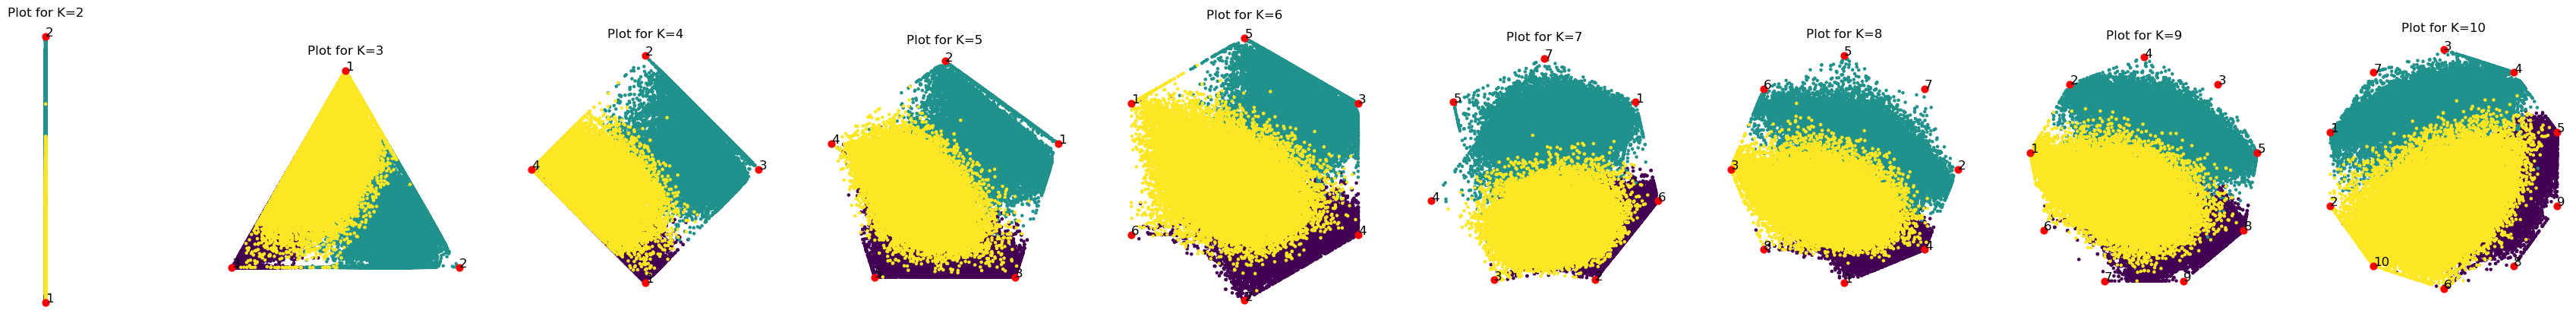

In [36]:
# plot_AA_reconstructed_angles_multiple(X: np.ndarray, Cs: list, Ss: list, Ks: list, y: np.ndarray, point_size: int=10):
plot_AA_reconstructed_angles_multiple(X, C_list, S_list, K_list, y, point_size=5)

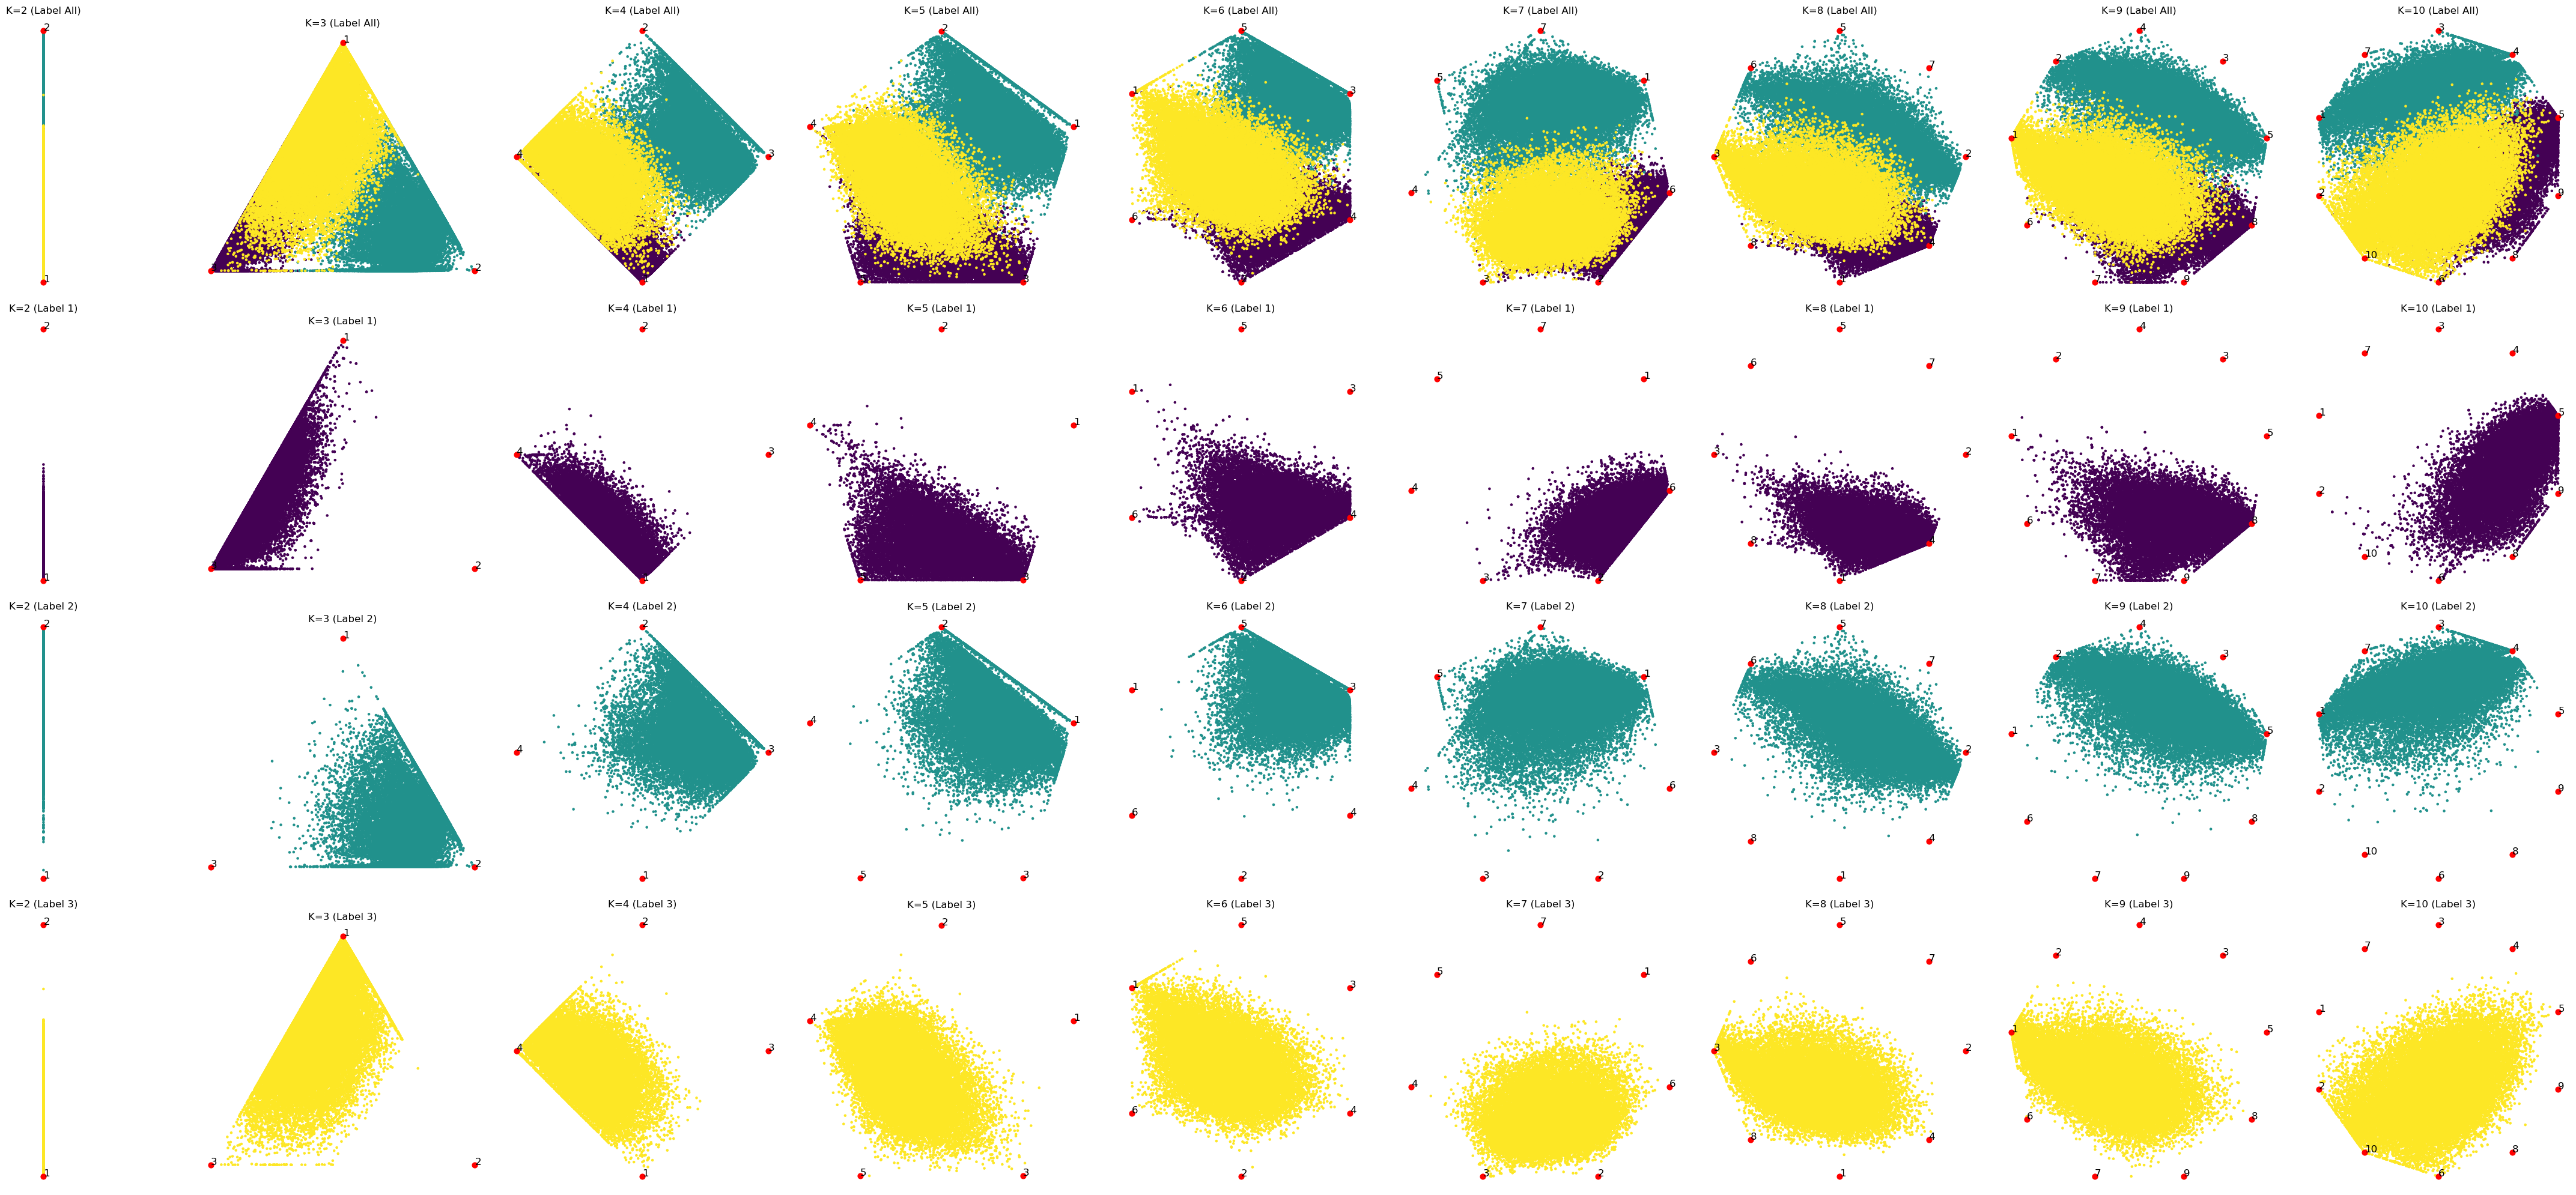

In [37]:
plot_AA_reconstructed_angles_multiple_sep(X, C_list, S_list, K_list, y, point_size=5)